## Wprowadzenie
Ten notebook będzie kontynuacją poprzedniego. Jednak w tym notebooku zajmiemy się poprawieniem modelu za pomocą sieci rekurencyjnych. Jako sekwencję potraktujemy ciąg kolejnych znaków. Zacznijmy od przeniesienia wszystkich funkcji z poprzedniego notebooka potrzebnych do zaczęcia uczenia modeli

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import string
from pathlib import Path

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models

import matplotlib.pyplot as plt

## Zakodowanie etykiet

In [2]:
data_dir = Path("./dataset/samples/")

images_paths = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img_path.split(os.path.sep)[-1].split(".png")[0] for img_path in images_paths]
characters = set(char for label in labels for char in label)
characters = sorted(list(characters))

print("Number of images found: ", len(images_paths))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

batch_size = 16

img_width = 200
img_height = 50

downsample_factor = 4

max_length = max([len(label) for label in labels])

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  ['2', '3', '4', '5', '6', '7', '8', 'b', 'c', 'd', 'e', 'f', 'g', 'm', 'n', 'p', 'w', 'x', 'y']


In [3]:
characters = string.ascii_lowercase + "0123456789" 
characters = set(char for char in characters)
characters = sorted(list(characters))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

Number of unique characters:  36
Characters present:  ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Funkcja kodująca przykłady uczące:

In [4]:
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [img_height, img_width])
    # Transponujmy obrazek, żeby był zachowany wymiar czasu
    img = tf.transpose(img, perm=[1, 0, 2])
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    return img, label

In [5]:
print("Vocabulary: ", char_to_num.get_vocabulary())

Vocabulary:  ['[UNK]', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Image path:  dataset\samples\226md.png
Label:  226md


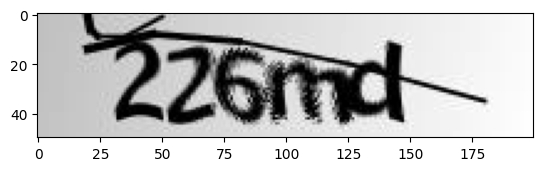

Label encoded:  tf.Tensor([ 3  3  7 23 14], shape=(5,), dtype=int64)


In [6]:
image_path = images_paths[0]
label = labels[0]
print("Image path: ", image_path)
print("Label: ", label)

img_encoded, label_encoded = encode_single_sample(image_path, label)
plt.imshow(img_encoded.numpy().transpose((1,0,2)), 'gray')
plt.show()
print('Label encoded: ', label_encoded)

## Preprocesing

In [7]:
def split_data(images_paths, labels, train_size=0.9, shuffle=True):
    size = len(images_paths)
    indices = np.arange(size)
    if shuffle:
        np.random.shuffle(indices)
    train_samples = int(size * train_size)
    x_train, y_train = images_paths[indices[:train_samples]], labels[indices[:train_samples]]
    x_valid, y_valid = images_paths[indices[train_samples:]], labels[indices[train_samples:]]
    return x_train, x_valid, y_train, y_valid


x_train, x_valid, y_train, y_valid = split_data(np.array(images_paths), np.array(labels))

## Utwórzmy zbiór trenujący i uczący

In [8]:
def create_dataset(paths, labels):
    X , y =[], []
    for i in range(paths.shape[0]):
        img, label = encode_single_sample(paths[i], labels[i])
        X.append(img)
        y.append(label)
    X = np.array(X)
    y = np.array(y)
    return X, y

X_train, y_train = create_dataset(x_train, y_train)
X_valid, y_valid = create_dataset(x_valid, y_valid)

## Definicja funkcji rysujących wykresy

In [9]:
def PlotAccuracyComparison(acc, val_acc, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'bo', label='Training accuracy for ' + lab)
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy for ' + lab)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()

def PlotLossComparison(loss, val_loss, lab = ''):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss))
    plt.plot(epochs, loss, 'bo', label='Training loss for ' + lab)
    plt.plot(epochs, val_loss, 'b', label='Validation loss for ' + lab)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train ' + lab, 'Test ' + lab], loc='upper left')
    plt.show()

def PlotTwoAccuracyComparison(acc1, val_acc1, acc2, val_acc2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(acc1))
    plt.plot(epochs, acc1, 'bo', label='Training accuracy for ' + lab1)
    plt.plot(epochs, val_acc1, 'b', label='Validation accuracy for ' + lab1)
    plt.plot(epochs, acc2, 'ro', label='Training accuracy for ' + lab2)
    plt.plot(epochs, val_acc2, 'r', label='Validation accuracy for ' + lab2)
    plt.title('Comparison of Training and Validation Accuracies')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

def PlotTwoLossComparison(loss1, val_loss1, loss2, val_loss2, lab1 = 'Model 1', lab2 = 'Model 2'):
    plt.clf()   # clear figure
    #plt.rcParams['figure.figsize'] = (15.0, 5.0) # set default size of plots
    plt.figure(figsize=(15,5))
    #plt_inline()
    epochs = range(len(loss1))
    plt.plot(epochs, loss1, 'bo', label='Training loss for ' + lab1)
    plt.plot(epochs, val_loss1, 'b', label='Validation loss for ' + lab1)
    plt.plot(epochs, loss2, 'ro', label='Training loss for ' + lab2)
    plt.plot(epochs, val_loss2, 'r', label='Validation loss for ' + lab2)
    plt.title('Comparison of Training and Validation Losses')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(['Train '+ lab1, 'Test ' + lab1, 'Train '+ lab2, 'Test ' + lab2], loc='upper left')
    plt.show()

# Modele
W tym kroku wykorzystamy informację z artykułu: [Intuitively Understanding Connectionist Temporal Classification](https://towardsdatascience.com/intuitively-understanding-connectionist-temporal-classification-3797e43a86c) oraz [An End-to-End Trainable Neural Network for Image-based Sequence
Recognition and Its Application to Scene Text Recognition](https://arxiv.org/pdf/1507.05717.pdf). Zbudujemy model używający warstw CNN do wydobycia sekwencji z obrazu, a następnie przekażemy ją do warstw RNN do rozpropagowania tej informacji przez tę sekwencję. Te dwie operacje zwracją znak dla każdego elementu sekwencji, który jest po prostu reprezentowany przez macierz. Mając tą macierz, chcemy:
* obliczyć loss value, żeby uczyć sieć,
* rozkodować macierz, żeby rozczytać co nasza sieć wykryła

Osiągnąć to możemy za pomocą **CTC operation** 
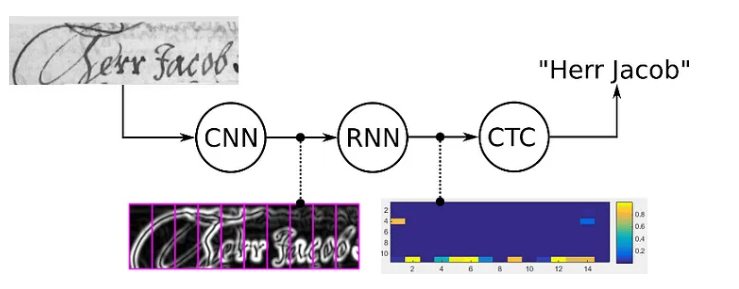

Wcześniej pojawiał się problem, że NN wypluwało na wyjściu znak dla każdej pozycji przez co nie dostawaliśmy ostatecznego rezultatu. Dla przykładu:
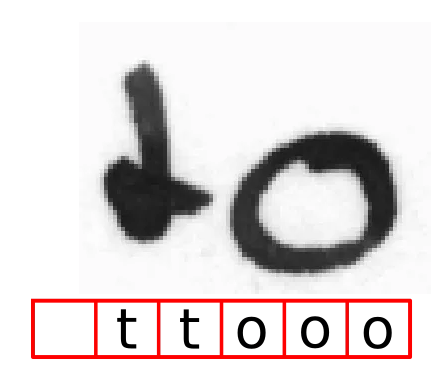
Problemy te rozwiązuje CTC

### Jak właściwie działa warstwa CTC?
Nie chcemy dodawać adnotacji do obrazów w każdej pozycji poziomej (time-step). Trening NN będzie prowadzony przez funkcję straty CTC. Podajemy tylko macierz wyjściową NN i odpowiedni tekst ground-truth (GT) do funkcji straty CTC. Ale skąd wie, gdzie występuje każdy znak? Właściwie to nie wie. Zamiast tego próbuje wszystkich możliwych połączeń tekstu GT na obrazie i pobiera sumę wszystkich wyników. W ten sposób wynik tekstu GT jest wysoki, jeśli suma wyników wyrównania ma wysoką wartość.
#### Kodowanie tekstu
Wprowadzamy pseudo-znak (najczęsciej biały znak), który zostanie usunięty przy dekodowaniu. Wstawiamy go między zduplikowane znaki. Dla przykładu:
* “to” → “---ttttttooo”, or “-t-o-”, or “to”
* “too” → “---ttttto-o”, or “-t-o-o-”, or “to-o”, but not “too”
#### Obliczanie funkcji straty
Dla każdego kroku na wyjściu dostajemy macierz, gdzie na każdej pozycji znajduje się prawdopodobieństwo z jakim na tym miejscu jest ten znak. Przykład:
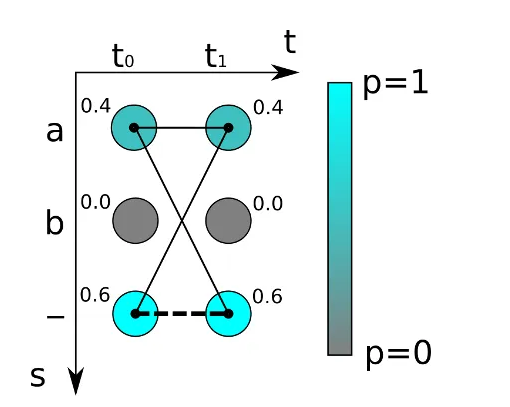
Strata jest obliczana przez zsumowanie wszystkich wyników wszystkich możliwych wyrównań tekstu GT. Na przykład dla 'a' będą to:
'a-', '-a', 'aa'. Czyli wartość funkcji straty wyniesie: `0.4·0.4+0.4·0.6+0.6·0.4=0.64`
#### Dekodowanie
Prostym i bardzo szybkim algorytmem jest dekodowanie najlepszej ścieżki, które składa się z dwóch kroków:
* oblicza najlepszą ścieżkę, biorąc najbardziej prawdopodobny znak na krok czasowy.
* cofa kodowanie, najpierw usuwając zduplikowane znaki, a następnie usuwając wszystkie spacje ze ścieżki. To, co pozostaje, reprezentuje rozpoznany tekst.
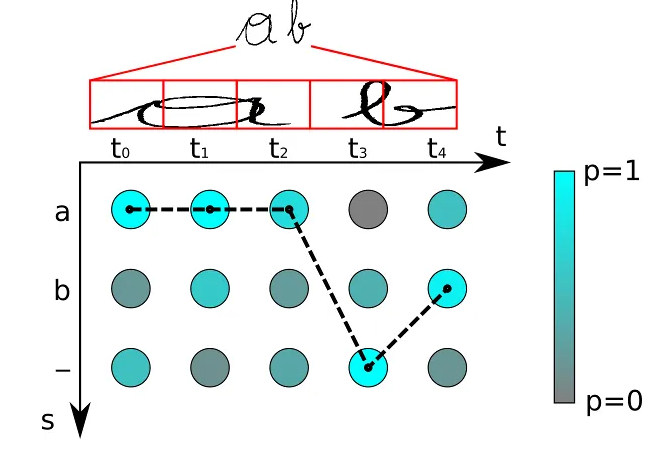

Skoro już wiemy jak działa CTC loss przejdźmy do zaimplementowania funkcji

In [10]:
loss_fn = keras.backend.ctc_batch_cost

def CTC_loss(y_true, y_pred):
    batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64") # 16
    input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64") # 50
    label_length = tf.cast(tf.shape(y_true)[1], dtype="int64") # 5

    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

    loss = loss_fn(y_true, y_pred, input_length, label_length)
    return loss

Mając tę warstwę przejdźmy do zbudowania modelu. Model będzie oparty o architekturę używaną do rozpoznawania napisów z obrazka, czyli CRNN(Convolutional Recurrent Neural Network)
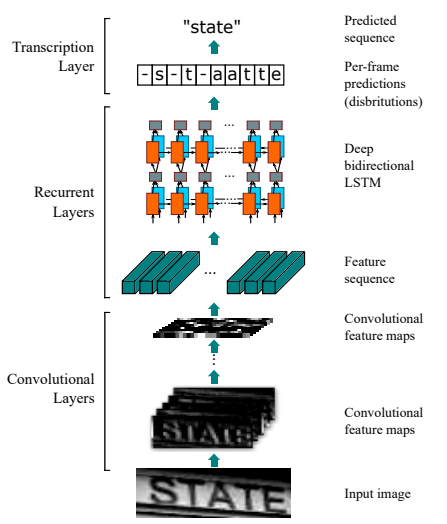

* CNN - utworzenie sekwencyjnej reprezentacji cech. Każdy wektor zawiera zbiór map. Sekwencja jest generowana od lewej do prawej na mapach obiektów według kolumny. Oznacza to, że i-ty wektor cech jest konkatenacją i-tych kolumn wszystkich map. 
* RNN - nie musimy traktować każdego elementu osobno, bo mamy sekwencję map

* zostawmy liczbę warstw konwolucyjnych taką samą jak wcześniej
* zróbmy reshape do rozmiaru po 2 warstwach konwolucyjnych - nie musimy już dzielić obrazka na 5 częsci (tyle co znaków) - mamy teraz sekwencję cech
* dodajmy 2 warstwy Bidirectional LSTM - jednokierunkowe warstwy pamiętają tylko to co przeszły,a potrzebujemy mieć dla danej mapy kontekst

In [164]:
def build_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(16, (3, 3), activation="relu", padding="same", name="Conv1", input_shape=(img_width, img_height, 1)))
    model.add(layers.MaxPooling2D((2, 2), name="pool1"))
    
    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="Conv2"))
    model.add(layers.MaxPooling2D((2, 2), name="pool2"))

    new_shape = ((img_width // 4), (img_height // 4) * 32)
    model.add(layers.Reshape(target_shape=new_shape, name="Reshape"))
    model.add(layers.Dense(32, activation="relu", name="dense1"))

    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, name='BidirectionalRnn1')))
    model.add(layers.Bidirectional(layers.LSTM(32, return_sequences=True, name='BidirectionalRnn2')))


    model.add(layers.Dense(len(char_to_num.get_vocabulary()), activation='softmax', name='dense2'))


    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=CTC_loss)

    return model

model = build_model()
model.summary()

Model: "sequential_24"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 200, 50, 16)       160       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 16)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 32)       4640      
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 32)        0         
                                                                 
 Reshape (Reshape)           (None, 50, 384)           0         
                                                                 
 dense1 (Dense)              (None, 50, 32)            12320     
                                                                 
 bidirectional_42 (Bidirecti  (None, 50, 128)        

In [165]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    epochs=30)

Epoch 1/30
30/30 [==============================] - 8s 96ms/step - loss: 57.5376 - val_loss: 19.6747
Epoch 2/30
30/30 [==============================] - 1s 48ms/step - loss: 17.7459 - val_loss: 16.9207
Epoch 3/30
30/30 [==============================] - 1s 46ms/step - loss: 16.8083 - val_loss: 16.5919
Epoch 4/30
30/30 [==============================] - 1s 47ms/step - loss: 16.5937 - val_loss: 16.4908
Epoch 5/30
30/30 [==============================] - 1s 47ms/step - loss: 16.5083 - val_loss: 16.4144
Epoch 6/30
30/30 [==============================] - 2s 54ms/step - loss: 16.4564 - val_loss: 16.3729
Epoch 7/30
30/30 [==============================] - 1s 49ms/step - loss: 16.4235 - val_loss: 16.3475
Epoch 8/30
30/30 [==============================] - 2s 53ms/step - loss: 16.4098 - val_loss: 16.3260
Epoch 9/30
30/30 [==============================] - 2s 59ms/step - loss: 16.3913 - val_loss: 16.3184
Epoch 10/30
30/30 [==============================] - 2s 65ms/step - loss: 16.3780 - val_los

Wygenerujmy wykres dla wartości funkcji straty:

<Figure size 640x480 with 0 Axes>

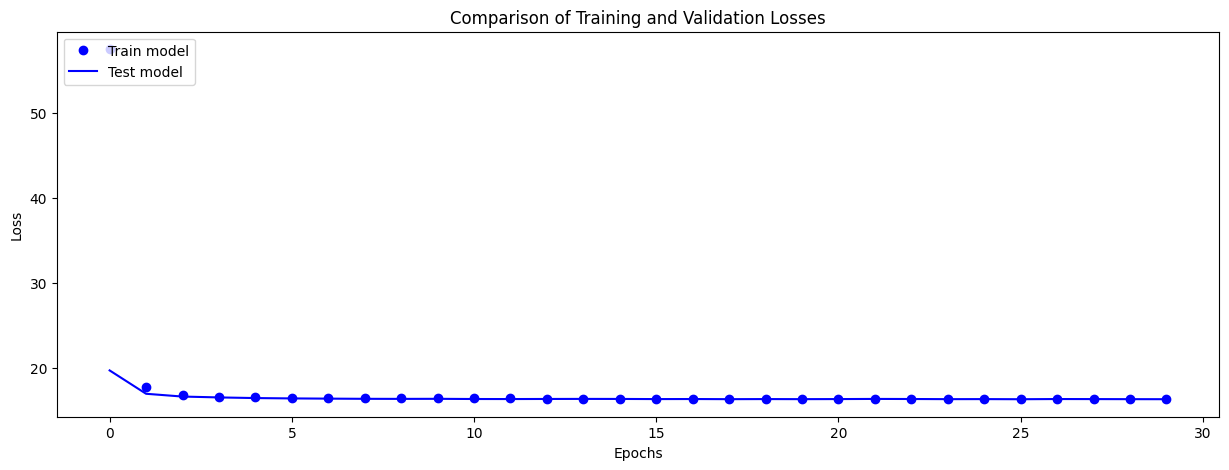

In [166]:
loss_model = history.history['loss']
val_loss_model = history.history['val_loss']

PlotLossComparison(loss_model, val_loss_model, lab = 'model')

Widzimy, że model się nie przeuczał, a wartość funkcji straty cały czas powoli malała. Popatrzmy na predykcję
#### Predykcja

In [13]:
voc = num_to_char.get_vocabulary()

In [14]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:5]
    output_text = []
    for result in results:
        result = tf.strings.reduce_join(num_to_char(result)).numpy().decode("utf-8")
        output_text.append(result)
    return output_text

4/4 [==============================] - 1s 16ms/step


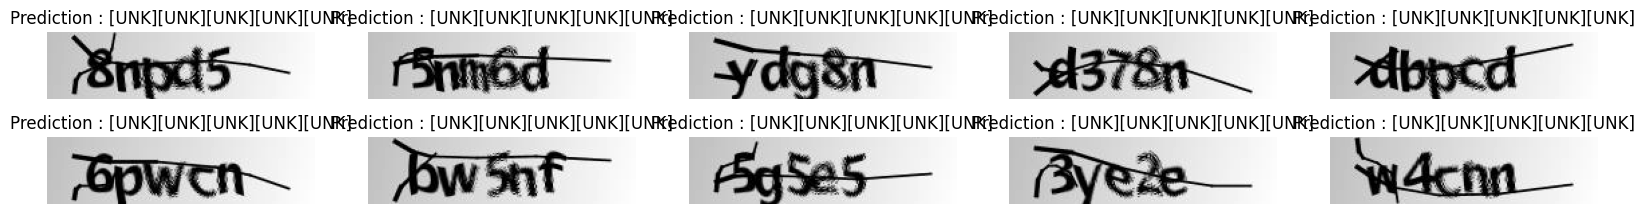

In [169]:
y_pred = model.predict(X_valid)
decoded_predictions =decode_batch_predictions(y_pred)

nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_valid[i].transpose([1, 0, 2]),cmap='gray')
    plt.title('Prediction : ' + decoded_predictions[i])
    plt.axis('off')
plt.show() 

Widzimy, że nasz model CRNN słabo się nauczył. W podanych przykładach nigdzie nie rozpoznał znaku
#### Skuteczność modelu
Stwórzmy funkcje, które po zakończeniu treningu umożliwą nam wyświetlenie accuracy treningu:

In [170]:
def decode_pred(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][:,:5]
    output_text = []
    for result in results:
        result = result.numpy()
        output_text.append(result)
    return output_text

In [171]:
def accuracy(X, y, model):
    y_pred = model.predict(X)
    y_pred = decode_pred(y_pred)
    all_samples = y.shape[0] * 5
    positive_classified_samples = 0
    for i in range(len(y)):
        for j in range(len(y_pred[i])):
            if y_pred[i][j] == y[i][j]:
                positive_classified_samples += 1
    return positive_classified_samples/all_samples

In [172]:
accuracy(X_train, y_train, model)

30/30 [==============================] - 1s 17ms/step


0.0

In [173]:
accuracy(X_valid, y_valid, model)

4/4 [==============================] - 0s 14ms/step


0.0

### Model 2
Jako, że nasz model powoli się uczył i się nie przetrenował zwiększmy liczbę neuronów na warstwach załóżmy dwukrotnie

In [184]:
def build_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="Conv1", input_shape=(img_width, img_height, 1)))
    model.add(layers.MaxPooling2D((2, 2), name="pool1"))
    
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv2"))
    model.add(layers.MaxPooling2D((2, 2), name="pool2"))

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    model.add(layers.Reshape(target_shape=new_shape, name="Reshape"))
    model.add(layers.Dense(64, activation="relu", name="dense1"))

    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, name='BidirectionalRnn1')))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, name='BidirectionalRnn2')))


    model.add(layers.Dense(len(char_to_num.get_vocabulary()), activation='softmax', name='dense2'))


    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=CTC_loss)

    return model

model = build_model()
model.summary()

Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 Reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216     
                                                                 
 bidirectional_46 (Bidirecti  (None, 50, 256)        

In [185]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    epochs=30)

Epoch 1/30
30/30 [==============================] - 8s 100ms/step - loss: 35.2901 - val_loss: 17.1504
Epoch 2/30
30/30 [==============================] - 2s 52ms/step - loss: 16.7701 - val_loss: 16.5007
Epoch 3/30
30/30 [==============================] - 2s 53ms/step - loss: 16.4738 - val_loss: 16.3558
Epoch 4/30
30/30 [==============================] - 2s 52ms/step - loss: 16.4270 - val_loss: 16.3920
Epoch 5/30
30/30 [==============================] - 2s 51ms/step - loss: 16.4154 - val_loss: 16.4015
Epoch 6/30
30/30 [==============================] - 2s 53ms/step - loss: 16.3900 - val_loss: 16.3392
Epoch 7/30
30/30 [==============================] - 2s 53ms/step - loss: 16.3748 - val_loss: 16.3711
Epoch 8/30
30/30 [==============================] - 2s 50ms/step - loss: 16.3680 - val_loss: 16.3331
Epoch 9/30
30/30 [==============================] - 2s 50ms/step - loss: 16.3616 - val_loss: 16.2848
Epoch 10/30
30/30 [==============================] - 1s 50ms/step - loss: 16.3651 - val_lo

<Figure size 640x480 with 0 Axes>

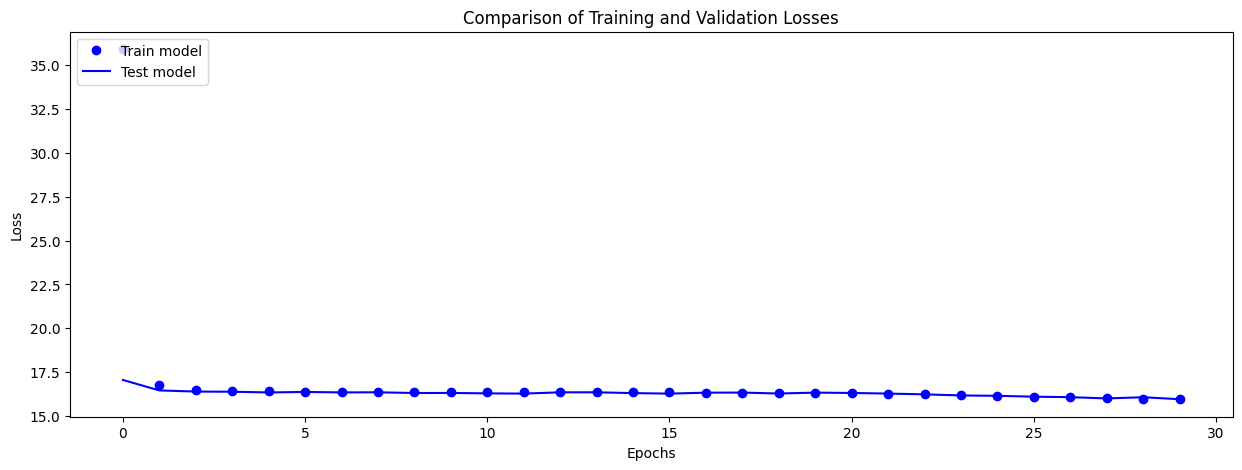

In [176]:
loss_model = history.history['loss']
val_loss_model = history.history['val_loss']

PlotLossComparison(loss_model, val_loss_model, lab = 'model')

Patrząc na nasz wykres model powoli się uczy. Popatrzmy na skuteczność modelu i uruchommy jeszcze raz ten sam model na 50 epok

In [186]:
accuracy(X_train, y_train, model)

30/30 [==============================] - 2s 23ms/step


0.0

In [187]:
accuracy(X_valid, y_valid, model)

4/4 [==============================] - 0s 16ms/step


0.0

In [188]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    epochs=50)

Epoch 1/50
30/30 [==============================] - 2s 52ms/step - loss: 15.9832 - val_loss: 16.0576
Epoch 2/50
30/30 [==============================] - 2s 53ms/step - loss: 15.9700 - val_loss: 15.9998
Epoch 3/50
30/30 [==============================] - 2s 52ms/step - loss: 15.9410 - val_loss: 15.9530
Epoch 4/50
30/30 [==============================] - 2s 51ms/step - loss: 15.9265 - val_loss: 15.9370
Epoch 5/50
30/30 [==============================] - 2s 51ms/step - loss: 15.9386 - val_loss: 15.9662
Epoch 6/50
30/30 [==============================] - 1s 50ms/step - loss: 15.9326 - val_loss: 16.0425
Epoch 7/50
30/30 [==============================] - 2s 51ms/step - loss: 15.9198 - val_loss: 15.9218
Epoch 8/50
30/30 [==============================] - 2s 51ms/step - loss: 15.9116 - val_loss: 15.8907
Epoch 9/50
30/30 [==============================] - 2s 50ms/step - loss: 15.9003 - val_loss: 15.9544
Epoch 10/50
30/30 [==============================] - 1s 49ms/step - loss: 15.8973 - val_los

<Figure size 640x480 with 0 Axes>

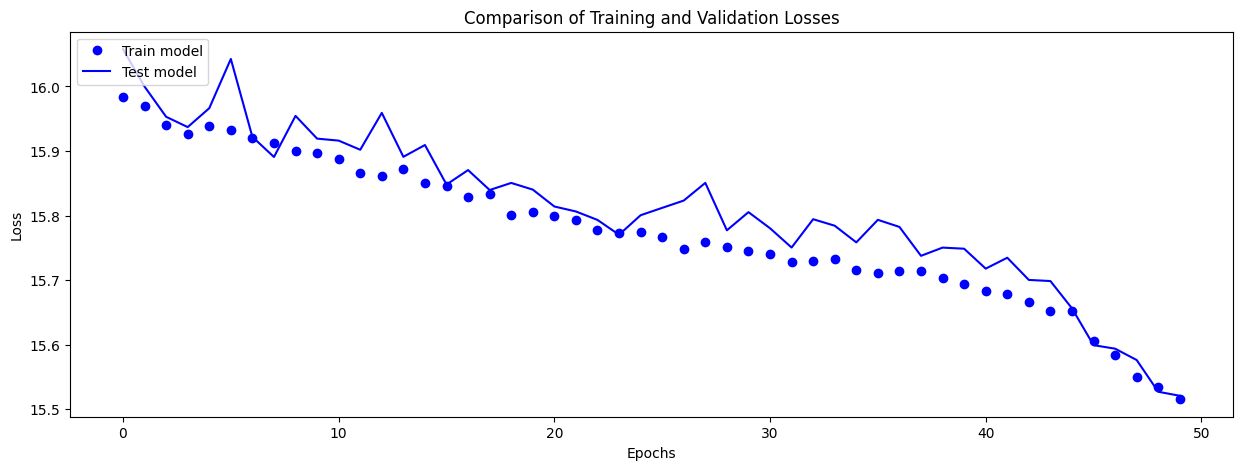

In [189]:
loss_model = history.history['loss']
val_loss_model = history.history['val_loss']

PlotLossComparison(loss_model, val_loss_model, lab = 'model')

Ucząć model dłużej doszliśmy do bardzo niskiej wartości straty na zbiorze walidacyjnym jak i testowym. Przy treningu na 30 epok było to około 4 na zbiorze walidacyjnym. Natomiast przy treningu przez 50 epok udało nam się zejść do wartości 0.23. Popatrzmy jak prezentuje się skuteczność naszego modelu:

In [190]:
accuracy(X_train, y_train, model)

30/30 [==============================] - 1s 20ms/step


0.057478632478632476

In [182]:
accuracy(X_valid, y_valid, model)

4/4 [==============================] - 0s 16ms/step


0.05576923076923077

Widzimy, że udało nam się dojść do 100% na zbiorze testowym i 98% na zbiorze walidacyjnym. Jest to bardzo dobry wynik! Popatrzmy jak prezentują się predykcje na zbiorze walidacyjnym:

4/4 [==============================] - 0s 52ms/step


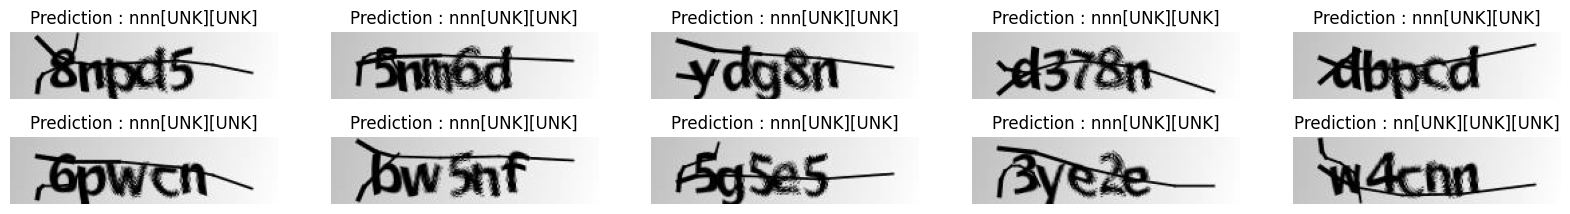

In [191]:
y_pred = model.predict(X_valid)
decoded_predictions =decode_batch_predictions(y_pred)

nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_valid[i].transpose([1, 0, 2]),cmap='gray')
    plt.title('Prediction : ' + decoded_predictions[i])
    plt.axis('off')
plt.show() 

### Model 3
Zwiększmy liczbę neuronów jeszcze raz

In [192]:
def build_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv1", input_shape=(img_width, img_height, 1)))
    model.add(layers.MaxPooling2D((2, 2), name="pool1"))
    
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="Conv2"))
    model.add(layers.MaxPooling2D((2, 2), name="pool2"))

    new_shape = ((img_width // 4), (img_height // 4) * 128)
    model.add(layers.Reshape(target_shape=new_shape, name="Reshape"))
    model.add(layers.Dense(64, activation="relu", name="dense1"))

    model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True, name='BidirectionalRnn1')))
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, name='BidirectionalRnn2')))


    model.add(layers.Dense(len(char_to_num.get_vocabulary()), activation='softmax', name='dense2'))


    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=CTC_loss)

    return model

model = build_model()
model.summary()

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 200, 50, 64)       640       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 64)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 128)      73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 128)       0         
                                                                 
 Reshape (Reshape)           (None, 50, 1536)          0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            98368     
                                                                 
 bidirectional_48 (Bidirecti  (None, 50, 512)        

In [193]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    epochs=50)

Epoch 1/50
30/30 [==============================] - 9s 124ms/step - loss: 32.0712 - val_loss: 16.5204
Epoch 2/50
30/30 [==============================] - 2s 66ms/step - loss: 16.5167 - val_loss: 16.4812
Epoch 3/50
30/30 [==============================] - 2s 64ms/step - loss: 16.4025 - val_loss: 16.3650
Epoch 4/50
30/30 [==============================] - 2s 65ms/step - loss: 16.3898 - val_loss: 16.3648
Epoch 5/50
30/30 [==============================] - 2s 65ms/step - loss: 16.3696 - val_loss: 16.3840
Epoch 6/50
30/30 [==============================] - 2s 65ms/step - loss: 16.3758 - val_loss: 16.2647
Epoch 7/50
30/30 [==============================] - 2s 67ms/step - loss: 16.3450 - val_loss: 16.3121
Epoch 8/50
30/30 [==============================] - 2s 66ms/step - loss: 16.3622 - val_loss: 16.3456
Epoch 9/50
30/30 [==============================] - 2s 65ms/step - loss: 16.3424 - val_loss: 16.2810
Epoch 10/50
30/30 [==============================] - 2s 65ms/step - loss: 16.3264 - val_lo

<Figure size 640x480 with 0 Axes>

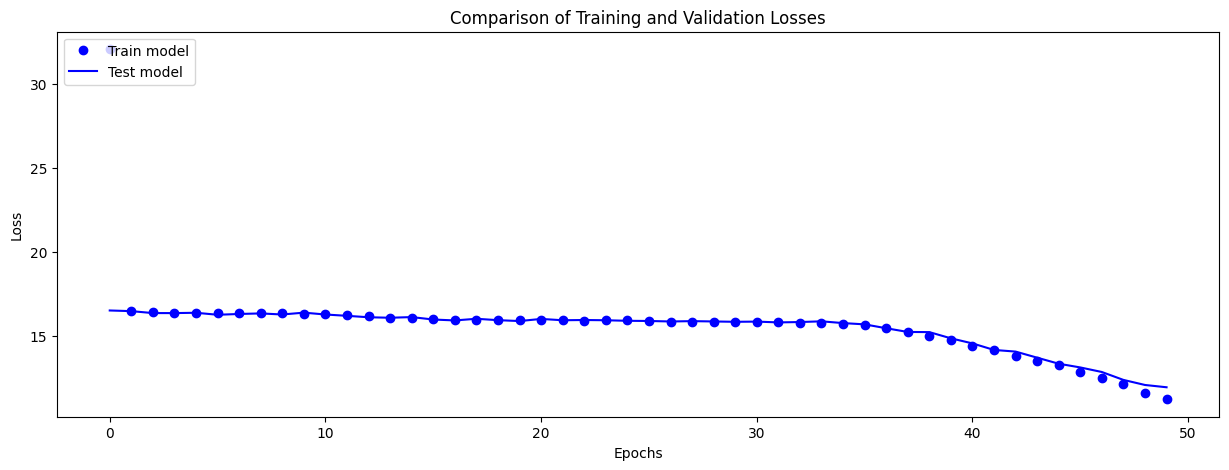

In [194]:
loss_model = history.history['loss']
val_loss_model = history.history['val_loss']

PlotLossComparison(loss_model, val_loss_model, lab = 'model')

Faktycznie przyniosło to zamierzony skutek. Udało nam się zejść do wartości funkcji straty równej 11. Ale dalej jest to za mało. Zobaczmy jak zachowa się sieć, gdy zwiększymy learning_rate

### Model 4

In [195]:
def build_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv1", input_shape=(img_width, img_height, 1)))
    model.add(layers.MaxPooling2D((2, 2), name="pool1"))
    
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="Conv2"))
    model.add(layers.MaxPooling2D((2, 2), name="pool2"))

    new_shape = ((img_width // 4), (img_height // 4) * 128)
    model.add(layers.Reshape(target_shape=new_shape, name="Reshape"))
    model.add(layers.Dense(64, activation="relu", name="dense1"))

    model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True, name='BidirectionalRnn1')))
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, name='BidirectionalRnn2')))


    model.add(layers.Dense(len(char_to_num.get_vocabulary()), activation='softmax', name='dense2'))


    opt = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=opt, loss=CTC_loss)

    return model

model = build_model()
model.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 200, 50, 64)       640       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 64)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 128)      73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 128)       0         
                                                                 
 Reshape (Reshape)           (None, 50, 1536)          0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            98368     
                                                                 
 bidirectional_50 (Bidirecti  (None, 50, 512)        

In [196]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    epochs=50)

Epoch 1/50
30/30 [==============================] - 9s 113ms/step - loss: 72.9340 - val_loss: 21.0696
Epoch 2/50
30/30 [==============================] - 2s 65ms/step - loss: 18.0483 - val_loss: 16.5852
Epoch 3/50
30/30 [==============================] - 2s 64ms/step - loss: 16.5003 - val_loss: 16.4271
Epoch 4/50
30/30 [==============================] - 2s 66ms/step - loss: 16.4255 - val_loss: 16.3794
Epoch 5/50
30/30 [==============================] - 2s 66ms/step - loss: 16.4131 - val_loss: 16.3276
Epoch 6/50
30/30 [==============================] - 2s 66ms/step - loss: 16.3805 - val_loss: 16.3682
Epoch 7/50
30/30 [==============================] - 2s 64ms/step - loss: 16.3988 - val_loss: 16.2683
Epoch 8/50
30/30 [==============================] - 2s 65ms/step - loss: 16.3743 - val_loss: 16.3695
Epoch 9/50
30/30 [==============================] - 2s 64ms/step - loss: 16.4093 - val_loss: 16.3896
Epoch 10/50
30/30 [==============================] - 2s 64ms/step - loss: 16.4257 - val_lo

Zwiększenie learning_rate nie pomogło. Model nie może trafić w globalne minimum cały czas je przeskakując i zostaje na poziomie wartości loss równej 16.4. Wróćmy do naszego poprzedniego modelu i puścmy trening na 100 epok
### Model 3 uczony przez 100 epok

In [199]:
def build_model():
    model = keras.Sequential()
    
    # First conv block
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv1", input_shape=(img_width, img_height, 1)))
    model.add(layers.MaxPooling2D((2, 2), name="pool1"))
    
    # Second conv block
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="Conv2"))
    model.add(layers.MaxPooling2D((2, 2), name="pool2"))

    # Reshape
    new_shape = ((img_width // 4), (img_height // 4) * 128)
    model.add(layers.Reshape(target_shape=new_shape, name="Reshape"))
    model.add(layers.Dense(64, activation="relu", name="dense1"))

    # RNNs
    model.add(layers.Bidirectional(layers.LSTM(256, return_sequences=True, name='BidirectionalRnn1')))
    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, name='BidirectionalRnn2')))


    model.add(layers.Dense(len(char_to_num.get_vocabulary()), activation='softmax', name='dense2'))


    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=CTC_loss)

    return model

model = build_model()
model.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 200, 50, 64)       640       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 64)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 128)      73856     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 128)       0         
                                                                 
 Reshape (Reshape)           (None, 50, 1536)          0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            98368     
                                                                 
 bidirectional_54 (Bidirecti  (None, 50, 512)        

In [200]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    epochs=100)

Epoch 1/100
30/30 [==============================] - 9s 113ms/step - loss: 30.7841 - val_loss: 16.6056
Epoch 2/100
30/30 [==============================] - 2s 65ms/step - loss: 16.5128 - val_loss: 16.3683
Epoch 3/100
30/30 [==============================] - 2s 65ms/step - loss: 16.4256 - val_loss: 16.3712
Epoch 4/100
30/30 [==============================] - 2s 66ms/step - loss: 16.4035 - val_loss: 16.3423
Epoch 5/100
30/30 [==============================] - 2s 67ms/step - loss: 16.3992 - val_loss: 16.3317
Epoch 6/100
30/30 [==============================] - 2s 64ms/step - loss: 16.3694 - val_loss: 16.3348
Epoch 7/100
30/30 [==============================] - 2s 64ms/step - loss: 16.3842 - val_loss: 16.3728
Epoch 8/100
30/30 [==============================] - 2s 64ms/step - loss: 16.3730 - val_loss: 16.3497
Epoch 9/100
30/30 [==============================] - 2s 65ms/step - loss: 16.3634 - val_loss: 16.3130
Epoch 10/100
30/30 [==============================] - 2s 66ms/step - loss: 16.356

<Figure size 640x480 with 0 Axes>

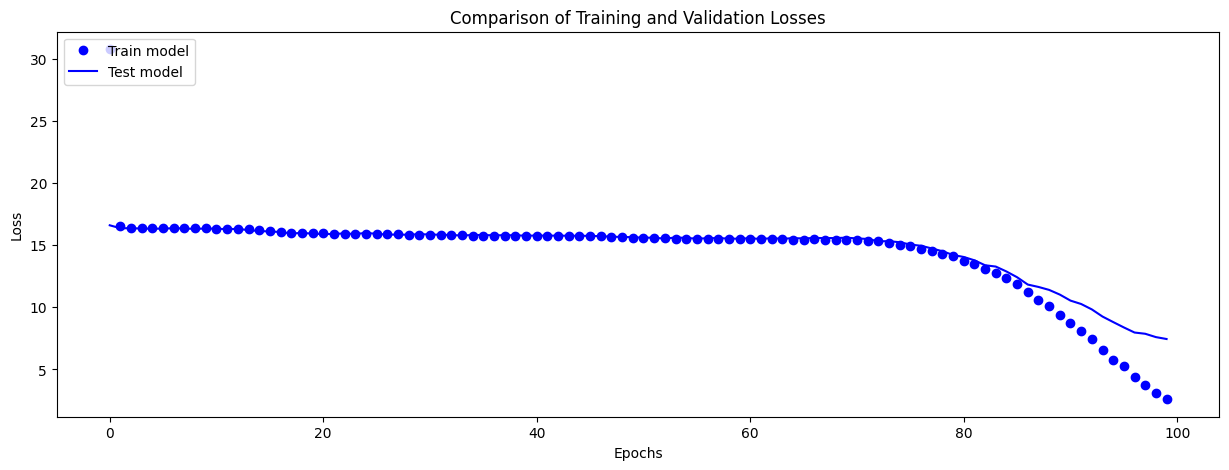

In [201]:
loss_model = history.history['loss']
val_loss_model = history.history['val_loss']

PlotLossComparison(loss_model, val_loss_model, lab = 'model')

Tym razem nasz model zaczął znacznie uczyć się po 80 epoce. Wykres wygląda tak jak wcześniej. Jedynie jest przesunięcie o 50 epok w prawo. Model CRNN nie zawsze można znaleźć optymalną ścieżkę a jak już ją znalazł to zaczął się przeuczać. Zmniejszmy złożoność modelu i learning_rate i sprawdźmy jak zachowa się model. Być może przy mniejszym learning_rate będzie mógł szybciej znaleźć optymalną ścieżkę

### Model 5

In [203]:
def build_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="Conv1", input_shape=(img_width, img_height, 1)))
    model.add(layers.MaxPooling2D((2, 2), name="pool1"))
    
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv2"))
    model.add(layers.MaxPooling2D((2, 2), name="pool2"))

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    model.add(layers.Reshape(target_shape=new_shape, name="Reshape"))
    model.add(layers.Dense(64, activation="relu", name="dense1"))

    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, name='BidirectionalRnn1')))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, name='BidirectionalRnn2')))


    model.add(layers.Dense(len(char_to_num.get_vocabulary()), activation='softmax', name='dense2'))


    opt = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=opt, loss=CTC_loss)

    return model

model = build_model()
model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 Reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216     
                                                                 
 bidirectional_58 (Bidirecti  (None, 50, 256)        

In [204]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    epochs=50)

Epoch 1/50
30/30 [==============================] - 9s 117ms/step - loss: 124.0555 - val_loss: 50.8384
Epoch 2/50
30/30 [==============================] - 2s 51ms/step - loss: 24.8414 - val_loss: 19.4352
Epoch 3/50
30/30 [==============================] - 2s 51ms/step - loss: 19.2286 - val_loss: 18.5206
Epoch 4/50
30/30 [==============================] - 2s 53ms/step - loss: 18.4907 - val_loss: 18.0276
Epoch 5/50
30/30 [==============================] - 2s 60ms/step - loss: 18.0227 - val_loss: 17.6408
Epoch 6/50
30/30 [==============================] - 2s 53ms/step - loss: 17.6407 - val_loss: 17.3214
Epoch 7/50
30/30 [==============================] - 2s 54ms/step - loss: 17.3379 - val_loss: 17.0913
Epoch 8/50
30/30 [==============================] - 2s 53ms/step - loss: 17.1119 - val_loss: 16.9136
Epoch 9/50
30/30 [==============================] - 2s 52ms/step - loss: 16.9389 - val_loss: 16.7928
Epoch 10/50
30/30 [==============================] - 2s 53ms/step - loss: 16.8123 - val_l

<Figure size 640x480 with 0 Axes>

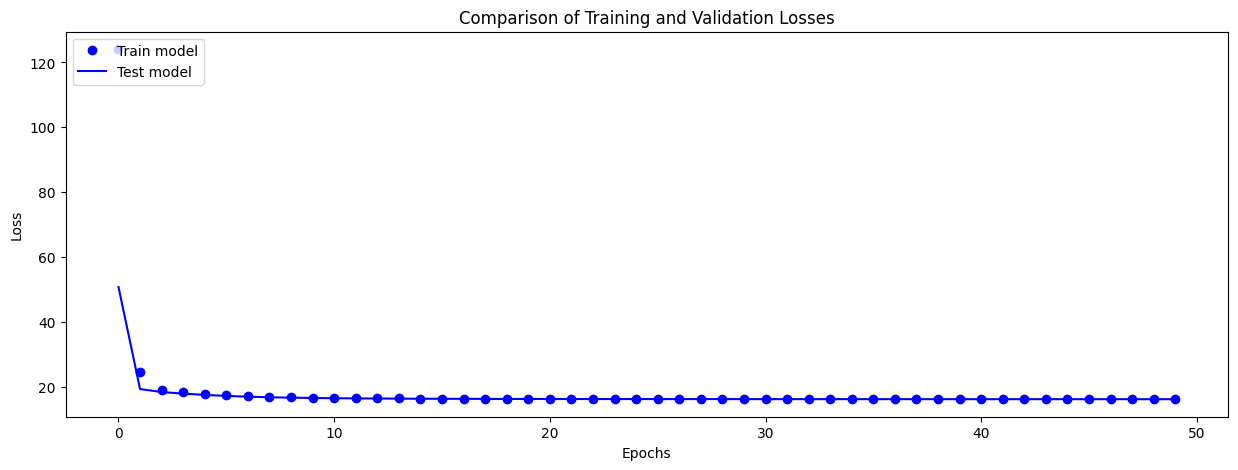

In [205]:
loss_model = history.history['loss']
val_loss_model = history.history['val_loss']

PlotLossComparison(loss_model, val_loss_model, lab = 'model')

Ze zmniejszonym learning rate model dłużej się uczy i po 50 epokach dochodzi do wartości funkcji straty równej 16, czyli nie jest to satysfkacjonujący wynik. Nie próbowalismy jeszcze uruchomić tego modelu na 100 epok z domyślnym współczynnikiem uczenia

In [206]:
def build_model():
    model = keras.Sequential()
    
    model.add(layers.Conv2D(32, (3, 3), activation="relu", padding="same", name="Conv1", input_shape=(img_width, img_height, 1)))
    model.add(layers.MaxPooling2D((2, 2), name="pool1"))
    
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="Conv2"))
    model.add(layers.MaxPooling2D((2, 2), name="pool2"))

    new_shape = ((img_width // 4), (img_height // 4) * 64)
    model.add(layers.Reshape(target_shape=new_shape, name="Reshape"))
    model.add(layers.Dense(64, activation="relu", name="dense1"))

    model.add(layers.Bidirectional(layers.LSTM(128, return_sequences=True, name='BidirectionalRnn1')))
    model.add(layers.Bidirectional(layers.LSTM(64, return_sequences=True, name='BidirectionalRnn2')))


    model.add(layers.Dense(len(char_to_num.get_vocabulary()), activation='softmax', name='dense2'))


    opt = keras.optimizers.Adam()
    model.compile(optimizer=opt, loss=CTC_loss)

    return model

model = build_model()
model.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 Reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216     
                                                                 
 bidirectional_60 (Bidirecti  (None, 50, 256)        

In [208]:
history = model.fit(X_train, y_train,
                    validation_data=(X_valid, y_valid),
                    batch_size=32,
                    epochs=100)

Epoch 1/100
30/30 [==============================] - 8s 100ms/step - loss: 33.7130 - val_loss: 17.2817
Epoch 2/100
30/30 [==============================] - 1s 49ms/step - loss: 16.7542 - val_loss: 16.4701
Epoch 3/100
30/30 [==============================] - 2s 50ms/step - loss: 16.4740 - val_loss: 16.3680
Epoch 4/100
30/30 [==============================] - 1s 50ms/step - loss: 16.4165 - val_loss: 16.3518
Epoch 5/100
30/30 [==============================] - 2s 50ms/step - loss: 16.3859 - val_loss: 16.3051
Epoch 6/100
30/30 [==============================] - 2s 51ms/step - loss: 16.3819 - val_loss: 16.4063
Epoch 7/100
30/30 [==============================] - 2s 53ms/step - loss: 16.3804 - val_loss: 16.3326
Epoch 8/100
30/30 [==============================] - 1s 50ms/step - loss: 16.3645 - val_loss: 16.2656
Epoch 9/100
30/30 [==============================] - 2s 51ms/step - loss: 16.3472 - val_loss: 16.3302
Epoch 10/100
30/30 [==============================] - 2s 50ms/step - loss: 16.345

<Figure size 640x480 with 0 Axes>

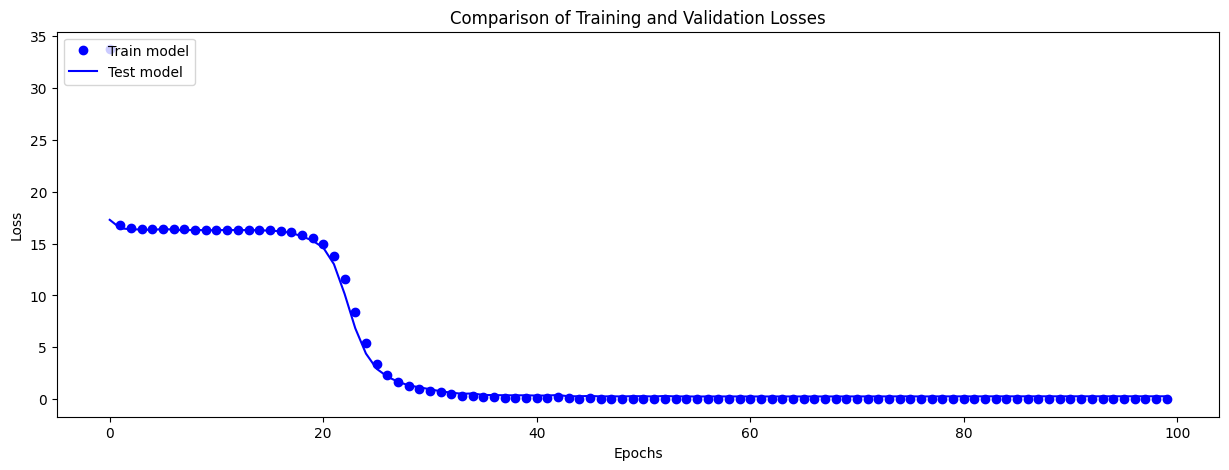

In [209]:
loss_model = history.history['loss']
val_loss_model = history.history['val_loss']

PlotLossComparison(loss_model, val_loss_model, lab = 'model')

Nasz model trafił na optymalną ścieżkę i osiągnął znakomite wyniki. Tak na prawdę nie było potrzebne, aż 100 epok, a jedynie 50. Na osiągnięcie globalnego minimum wpływ mogły mieć wagi zainicjalizowane na początku. Były one przydzielane całkowicie losowo i możliwe, że przy tej próbie trafiliśmy na optymalne rozwiązanie. Rzućmy okiem na metrykę skuteczności, która jest obliczana jako dobrze zaklasyfikowane znaki:

In [212]:
accuracy(X_train, y_train, model)

30/30 [==============================] - 2s 19ms/step


1.0

In [214]:
accuracy(X_valid, y_valid, model)

4/4 [==============================] - 0s 35ms/step


0.9942307692307693

Wyniki są bardzo dobre. Zapiszmy sobie model, ponieważ może nam się przydać później

In [215]:
model.save('models/ocr_model.h5')

Sprawdźmy czy został zapisany poprawnie:

In [218]:
loaded_model = keras.models.load_model('models/ocr_model.h5', custom_objects={ 'CTC_loss': CTC_loss })
accuracy(X_train, y_train, loaded_model)

30/30 [==============================] - 2s 24ms/step


1.0

In [219]:
accuracy(X_valid, y_valid, loaded_model)

4/4 [==============================] - 0s 76ms/step


0.9942307692307693

Model zapisał się poprawnie. Rzućmy okiem na predykcje:

4/4 [==============================] - 0s 46ms/step


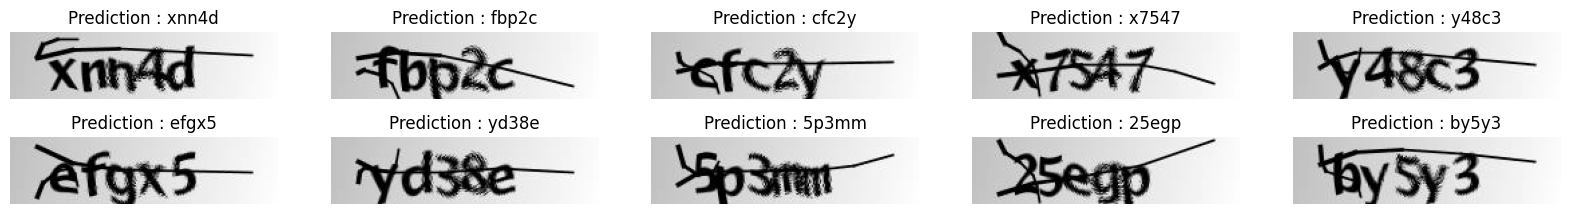

In [15]:
y_pred = model.predict(X_valid)
decoded_predictions =decode_batch_predictions(y_pred)

nrow = 1
fig=plt.figure(figsize=(20, 5))
for i in range(0,10):
    if i>4: nrow = 2
    fig.add_subplot(nrow, 5, i+1)
    plt.imshow(X_valid[i].transpose([1, 0, 2]),cmap='gray')
    plt.title('Prediction : ' + decoded_predictions[i])
    plt.axis('off')
plt.show() 

## Podsumowanie
W ramach stworzenia modelu potrafiącego rozpoznawać znaki na obrazkach Captcha zostały wykorzystane dwa rodzaje modeli: DCNN (CNN + Deep Neural Network) oraz RCNN(CNN + RNN). Poniżej zostaną przedstawione wnioski, a także najważniejsze różnice pomiędzy tymi dwoma podejściami.
#### Wnioski:
- etykiety dla obrazków kodujemy jako ciąg cyfr
- wyjściem z sieci są wektory o długości równej liczbie unikalnych cyfr. Zazwyczaj dla zwykłego alfabetu wektor będzie miał długość 36 + znak biały.
- obrazki z napisami warto transponować, ponieważ idąc oknami konwolucji idziemy od lewego górnego rogo do prawego dolnego. W przypadku gdy transponujemy macierz możemy zachować informację czasową <-> idziemy od góry do dołu czyli czytamy od lewej do prawej
- w przypadku analizowania sieci, które zawierają warstwy konwolucyjne bardzo pomocne są `wizualizacje pośrednich aktywacji i  filtrów`. Dzięki nim możemy ocenić dane wychodzące z warstw konwolucyjnych i dobrać optymalną część CNN dla naszego modelu
- wykorzystanie modelu RCNN pozwoliło lepiej wykrywać znaki niezależnie od przesunięcia,
- dzięki sieciom Bidirectional LSTM możemy wyłapywać kontekst obecnie rozważanej mapy cech,
- czasami model nie potrafi trafić na ścieżkę prowadzącą do optymalnego rozwiązania, dlatego istotnym jest próbowanie różnych kombinacji hiperparametrów

#### Porównanie CNN+Deep i RCNN:

<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-utu1{background-color:#ffce93;border-color:#ffce93;text-align:left;vertical-align:top}
.tg .tg-oe15{background-color:#ffffff;border-color:#ffffff;text-align:left;vertical-align:top}
.tg .tg-0pky{border-color:inherit;text-align:left;vertical-align:top}
</style>
<table class="tg">
<thead>
  <tr>
    <th class="tg-oe15"></th>
    <th class="tg-utu1">CNN + Deep Layers</th>
    <th class="tg-utu1">RCNN</th>
  </tr>
</thead>
<tbody>
  <tr>
    <td class="tg-utu1">Radzenie sobie z przesunięcie<br>znaków</td>
    <td class="tg-0pky">NIE</td>
    <td class="tg-0pky">TAK</td>
  </tr>
  <tr>
    <td class="tg-utu1">Długość rozpoznawanego tekstu</td>
    <td class="tg-0pky">Musimy znać liczbę znaków, którą <br>chcemy rozpoznać</td>
    <td class="tg-0pky">Nie musimy znać liczby znaków</td>
  </tr>
  <tr>
    <td class="tg-utu1">Funkcja straty</td>
    <td class="tg-0pky">Sparse Categorical Crossentropy</td>
    <td class="tg-0pky">Connectionist Temporal Classification</td>
  </tr>
  <tr>
    <td class="tg-utu1">Skuteczność na zbiorze<br>uczącym</td>
    <td class="tg-0pky">100%</td>
    <td class="tg-0pky">100%</td>
  </tr>
  <tr>
    <td class="tg-utu1">Skuteczność na zbiorze walidacyjnym</td>
    <td class="tg-0pky">93%</td>
    <td class="tg-0pky">99%</td>
  </tr>
</tbody>
</table>

Podsumowując głównymi zaletami sieci RCNN nad DCNN nie musimy zmieniać rozmiaru obrazka wejściowego oraz znać liczby znaków na obrazku. Co więcej dla naszego problemu rozpoznawania napisów Captcha osiągnęła lepsze wyniki - niemalże 100% skuteczności na zbiorze walidacyjnym, którego sieć nie widziała podczas uczenia